# 4. Disciplines of Journals using OJS <a name=languages></a>

### Notebook objectives:
1. Translate concatenated titles and abstracts from 9 other languages into English using [UKP's EasyNMT neural machine translation package](#nmt) with <a href='https://github.com/Helsinki-NLP/Opus-MT'>Helsinki NLP's Opus MT</a> and <a href='https://github.com/facebookresearch/fairseq'>Facebook Research's 'mbart50_m2en' model</a>. This is necessary because the classifier was trained on English text.<br><br>
2. Classify the journals known to be actively using OJS by applying [Weber et al.'s (2020) neural field of study classifier](#fosc) to titles and abstracts in 10 primary languages*
    * English, Bahasa Indonesia, Spanish, Portuguese, Ukrainian, Russian, German, Polish, French, Arabic
<br><br>
3. Create bar graphs representing the journals actively using OJS by their disciplinary distribution:
    1. [By discipline: 20 ANZSRC field of study labels](#disc)
        1. https://www.abs.gov.au/statistics/classifications/australian-and-new-zealand-standard-research-classification-anzsrc/latest-release
    2. [By division: STEM, Social Sciences, and Humanities](#div)
    3. [By language](#langs)

Import packages:

In [1]:
from collections import defaultdict
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import warnings
import json
import time
import re
import os

### 1. Translating jounal titles and abstracts with <a href='https://github.com/UKPLab/EasyNMT'>UKP's EasyNMT neural machine translator</a><a id='nmt'></a>

Import EasyNMT:

In [2]:
import tensorflow
from easynmt import EasyNMT

First, create a function that:
<br>
1. Reads each of the Indonesian, Spanish, and Portuguese .json files mapping journal ISSNs to concatenated article titles and abstracts, or payloads;
<br><br>
2. Translates the payloads for each journal from the specified source language ('id', 'es', 'pt') to the target language, English ('en');
<br><br>
3. Saves a dictionary mapping journal ISSN to translated payload as a .json file:

In [3]:
def translate(infile, outfile, issns_en, model, source_lang):
    issn2translation = {}
    
    with open(infile, 'r') as infile_:
        d = json.load(infile_)
        d_ = {}
        for k, v in d.items():
            if k not in issns_en:
                d_[k] = v
        del d   
        
    print('{} examples loaded.'.format(len(d_)))
    
    print('Translating payloads...')
    for k, v in tqdm(list(d_.items())):
        issn2translation[k] = model.translate(v, source_lang=source_lang, target_lang='en')
    
    with open(outfile, 'w') as outfile_:
        json.dump(issn2translation, outfile_)
    print('Translated payloads saved.')

In [4]:
infile_en = os.path.join('data', 'issn2en.json')
with open(infile_en, 'r') as infile:
    en = json.load(infile)
    issns_en = list(en.keys())
    
opus = EasyNMT('opus-mt') #Helsinki NLP Opus machine translation model (marian)

Bahasa Indonesia:

In [5]:
infile_id = os.path.join('data', 'issn2id.json')
outfile_id = os.path.join('data', 'issn2id_trans.json')
%time translate(infile=infile_id, outfile=outfile_id, issns_en=issns_en, model=opus, source_lang='id')

998 examples loaded.
Translating payloads...


100%|███████████████████████████████████████| 998/998 [6:31:37<00:00, 23.54s/it]

Translated payloads saved.
CPU times: user 6h 12s, sys: 2h 24min 13s, total: 8h 24min 26s
Wall time: 6h 31min 40s


Spanish:

In [6]:
infile_es = os.path.join('data', 'issn2es.json')
outfile_es = os.path.join('data', 'issn2es_trans.json')
%time translate(infile=infile_es, outfile=outfile_es, issns_en=issns_en, model=opus, source_lang='es')

588 examples loaded.
Translating payloads...


100%|███████████████████████████████████████| 588/588 [2:12:36<00:00, 13.53s/it]

Translated payloads saved.
CPU times: user 2h 4min 32s, sys: 38min 50s, total: 2h 43min 23s
Wall time: 2h 12min 37s


Portuguese:

In [7]:
mbart = EasyNMT('mbart50_m2en') #Facebook (Meta) mbart50_m2en for pt & uk -> en

In [8]:
infile_pt = os.path.join('data', 'issn2pt.json')
outfile_pt = os.path.join('data', 'issn2pt_trans.json')
%time translate(infile=infile_pt, outfile=outfile_pt, issns_en=issns_en, model=mbart, source_lang='pt')

557 examples loaded.
Translating payloads...


100%|██████████████████████████████████████| 557/557 [13:08:13<00:00, 84.91s/it]

Translated payloads saved.
CPU times: user 12h 7min 45s, sys: 3h 22min 29s, total: 15h 30min 14s
Wall time: 13h 8min 15s


Ukrainian:

In [9]:
infile_uk = os.path.join('data', 'issn2uk.json')
outfile_uk = os.path.join('data', 'issn2uk_trans.json')
%time translate(infile=infile_uk, outfile=outfile_uk, issns_en=issns_en, model=mbart, source_lang='uk')

8 examples loaded.
Translating payloads...


100%|█████████████████████████████████████████████| 8/8 [06:27<00:00, 48.38s/it]

Translated payloads saved.
CPU times: user 5min 54s, sys: 1min 36s, total: 7min 31s
Wall time: 6min 27s


Russian:

In [10]:
infile_ru = os.path.join('data', 'issn2ru.json')
outfile_ru = os.path.join('data', 'issn2ru_trans.json')
%time translate(infile=infile_ru, outfile=outfile_ru, issns_en=issns_en, model=opus, source_lang='ru')

15 examples loaded.
Translating payloads...


100%|███████████████████████████████████████████| 15/15 [03:26<00:00, 13.74s/it]

Translated payloads saved.
CPU times: user 3min 12s, sys: 55 s, total: 4min 7s
Wall time: 3min 26s


German:

In [11]:
infile_de = os.path.join('data', 'issn2de.json')
outfile_de = os.path.join('data', 'issn2de_trans.json')
%time translate(infile=infile_de, outfile=outfile_de, issns_en=issns_en, model=opus, source_lang='de')

57 examples loaded.
Translating payloads...


100%|███████████████████████████████████████████| 57/57 [05:01<00:00,  5.29s/it]

Translated payloads saved.
CPU times: user 4min 43s, sys: 1min 13s, total: 5min 56s
Wall time: 5min 2s


French:

In [12]:
infile_fr = os.path.join('data', 'issn2fr.json')
outfile_fr = os.path.join('data', 'issn2fr_trans.json')
%time translate(infile=infile_fr, outfile=outfile_fr, issns_en=issns_en, model=opus, source_lang='fr')

99 examples loaded.
Translating payloads...


100%|███████████████████████████████████████████| 99/99 [07:21<00:00,  4.46s/it]

Translated payloads saved.
CPU times: user 6min 47s, sys: 1min 48s, total: 8min 35s
Wall time: 7min 22s


Polish:

In [13]:
infile_pl = os.path.join('data', 'issn2pl.json')
outfile_pl = os.path.join('data', 'issn2pl_trans.json')
%time translate(infile=infile_pl, outfile=outfile_pl, issns_en=issns_en, model=opus, source_lang='pl')

10 examples loaded.
Translating payloads...


100%|███████████████████████████████████████████| 10/10 [00:55<00:00,  5.51s/it]

Translated payloads saved.
CPU times: user 48 s, sys: 13.6 s, total: 1min 1s
Wall time: 55.3 s


Arabic:

In [14]:
infile_ar = os.path.join('data', 'issn2ar.json')
outfile_ar = os.path.join('data', 'issn2ar_trans.json')
%time translate(infile=infile_ar, outfile=outfile_ar, issns_en=issns_en, model=opus, source_lang='ar')

11 examples loaded.
Translating payloads...


100%|███████████████████████████████████████████| 11/11 [01:22<00:00,  7.55s/it]

Translated payloads saved.
CPU times: user 1min 14s, sys: 18.2 s, total: 1min 32s
Wall time: 1min 23s


### 2. OJS Field of Study Classification<a id='fosc'></a>
<br>
Instantiate <a href='https://direct.mit.edu/qss/article/1/2/525/96148/Using-supervised-learning-to-classify-metadata-of'>Weber et al.'s (2020)</a> feedforward neural net for classifying academic fields of study:

In [16]:
from fosc import load_model, vectorize
from fosc.config import config
model_id = 'mlp_l'
model = load_model(model_id)

Create a dict mapping the labels of the fosc classifier `int` to `str`:

In [17]:
anzsrc = {
    0:'Mathematical Sciences',
    1:'Physical Sciences',
    2:'Chemical Sciences',
    3:'Earth and Environmental Sciences',
    4:'Biological Sciences',
    5:'Agricultural and Veterinary Sciences',
    6:'Information and Computing Sciences',
    7:'Engineering and Technology',
    8:'Medical and Health Sciences',
    9:'Built Environment and Design',
    10:'Education',
    11:'Economics',
    12:'Commerce, Management, Tourism and Services',
    13:'Studies in Human Society',
    14:'Psychology and Cognitive Sciences',
    15:'Law and Legal Studies',
    16:'Studies in Creative Arts and Writing',
    17:'Language, Communication and Culture',
    18:'History and Archaeology',
    19:'Philosophy and Religious Studies'
}

Group the <a href='https://www.abs.gov.au/statistics/classifications/australian-and-new-zealand-standard-research-classification-anzsrc/latest-release'>20 ANZSRC labels</a> into three broad divisions: STEM, Social Sciences, and Humanities

In [18]:
STEM = ['Agricultural and Veterinary Sciences', 
        'Biological Sciences', 
        'Built Environment and Design', 
        'Chemical Sciences',
        'Earth and Environmental Sciences',
        'Engineering and Technology',
        'Information and Computing Sciences',
        'Mathematical Sciences',
        'Medical and Health Sciences',
        'Physical Sciences']

SOCSCI = ['Commerce, Management, Tourism and Services',
          'Economics',
          'Education',
          'Law and Legal Studies',
          'Psychology and Cognitive Sciences',
          'Studies in Human Society']

HUM = ['History and Archaeology',
       'Language, Communication and Culture',
       'Philosophy and Religious Studies',
       'Studies in Creative Arts and Writing']

Create a short helper function for converting integer labels to text labels:

In [19]:
def assign_discipline(row):
    return anzsrc[row['discipline']]

Create a function that:
<br>
1. Reads a .json file with a dictionary mapping journal issn to a payload of concatenated article abstracts for each journal;
<br><br>
2. Passes each payload to Weber et al.'s field of study classifier (fosc);
<br><br>
3. Selects the most likely field of study label :

In [20]:
def fosc(df, model_id, model):
 
    print('{} examples loaded.'.format(len(df)))

    vectorized = vectorize(df['payload'], model_id)
    preds = pd.DataFrame(model.predict(vectorized))
    payDF = df.join(preds)

    #select a primary field of study classification label
    payDF['discipline'] = payDF[[i for i in range(0, 20)]].idxmax(axis=1)
    payDF['discipline'] = payDF.apply(assign_discipline, axis=1)
    print('Journals classified.')
    
    #return a final DF of discipline counts
    countDF = pd.DataFrame(payDF['discipline'].value_counts())
    countDF.reset_index(inplace=True)
    countDF = countDF.rename(columns = {'index':'Discipline',
                                        'discipline': 'Count'})
    return payDF, countDF

### Visualize <a id='visuals'></a>

#### English, Bahasa Indonesia, Spanish, Portuguese, Ukrainian, Russian, German, Polish, French, Arabic: <a id='all'></a>

In [21]:
def aggregate_payloads(data_dir, json_files):
    
    issn2payload = defaultdict(str)
    
    for file in json_files:
        
        with open(os.path.join(data_dir, file), 'r') as f:
            payloads = json.load(f)
            
        for k, v in payloads.items():
            issn2payload[k] += v

    df = pd.DataFrame({'issn': issn2payload.keys(), 'payload':issn2payload.values()})
    print('''{} journals ready for classification.'''.format(len(df)))
    
    return df

In [22]:
data_dir = os.path.join('data')
json_files = []

for root, dirs, files in os.walk(data_dir, topdown=False):
    for file in files:
        if file.endswith('en.json'):
            json_files.append(file)
        elif file.endswith('_trans.json'):
            json_files.append(file)
        else:
            continue
print('Number of languages: {}'.format(len(json_files)))
for filename in sorted(json_files):
    print(filename)

Number of languages: 10
issn2ar_trans.json
issn2de_trans.json
issn2en.json
issn2es_trans.json
issn2fr_trans.json
issn2id_trans.json
issn2pl_trans.json
issn2pt_trans.json
issn2ru_trans.json
issn2uk_trans.json


In [23]:
issn2payload = aggregate_payloads(data_dir=data_dir, json_files=json_files)

22504 journals ready for classification.


In [24]:
with open(os.path.join('data','issn2payload.json'), 'w') as outfile:
    json.dump(issn2payload.to_dict(), outfile)

In [25]:
%%time 

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    payDF, countDF = fosc(
        df=issn2payload, 
        model_id=model_id, 
        model=model)

22504 examples loaded.
Journals classified.
CPU times: user 54.6 s, sys: 7.77 s, total: 1min 2s
Wall time: 44.9 s


In [26]:
filepath = os.path.join(data_dir, 'issn2discipline.csv')
payDF.to_csv(filepath)
payDF.head(2)

,issn,payload,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,discipline
0,2175-2516,"Between monsters, snakes and story characters ...",2.032268e-15,5.574727e-10,9.363107e-17,3.445756e-10,1.227949e-14,4.580785e-10,1.070286e-09,8.352980e-10,...,2.850803e-06,9.204795e-06,0.036553,1.153986e-07,1.564752e-05,5.751222e-06,0.277132,3.802329e-03,6.752845e-07,"Language, Communication and Culture"
1,2444-9431,GENDER AND SEX: STRATEGY TO PROMOTE DEBATES IN...,1.534574e-12,4.896613e-10,1.204546e-13,9.130932e-08,3.994525e-10,2.868499e-12,1.056048e-07,3.109392e-09,...,6.194448e-09,1.649721e-08,0.729716,2.441745e-07,5.206850e-07,1.149365e-08,0.000118,1.134768e-08,2.480964e-08,Studies in Human Society


#### A. Disciplines of journals using OJS to publish in top 10 primary languages* ($\it{n}$ = 22,504)<a id=disc></a>
* English, Bahasa Indonesia, Spanish, Portuguese, Ukrainian, Russian, German, Polish, French, Arabic

In [27]:
sns.set_theme(style="whitegrid", font_scale=1.25)

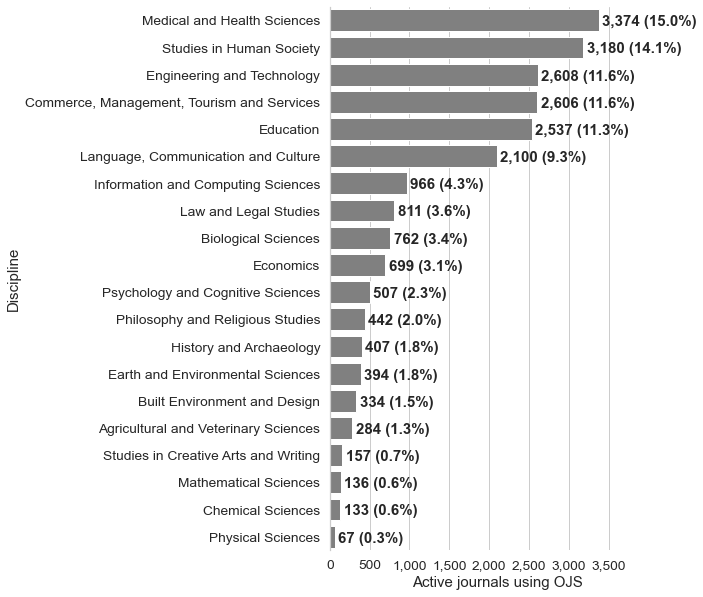

In [28]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x="Count", y="Discipline", data=countDF,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 4200),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline')#,
       #title = 'Disciplines of journals using OJS to publish in top 10 primary languages* ($\it{n}$ = 22,504)')

matplotlib.pyplot.xticks([0, 500, 1000, 1500, 2000, 2500, 3000, 3500],
                         ['0', '500', '1,000', '1,500', '2,000', '2,500', '3,000',  '3,500'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.2
    percent = round(((p.get_width() / 22504) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 42, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'OJSdisciplines.png'), bbox_inches='tight')

In [29]:
pivot = countDF.pivot_table(columns='Discipline')

d = {'Division': ['Social Sciences', 'STEM', 'Humanities'],
     'Count': [pivot[SOCSCI].values.sum(axis=1)[0],
               pivot[STEM].values.sum(axis=1)[0],
               pivot[HUM].values.sum(axis=1)[0]]}
d

{'Division': ['Social Sciences', 'STEM', 'Humanities'],
 'Count': [10340, 9058, 3106]}

#### B. Distribution of journals using OJS to publish in 10 primary languages by their disciplinary coverage ($\it{n}$ = 22,544)<a id=div></a>
* English, Bahasa Indonesia, Spanish, Portuguese, Afrikaans, Russian, Ukrainian, German, French, Japanese

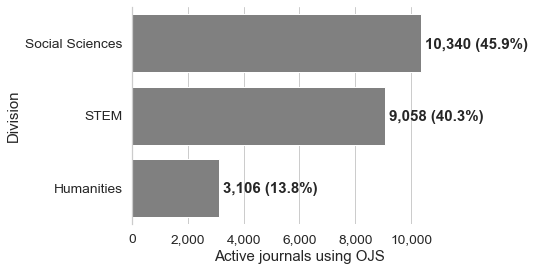

In [30]:
fig, ax = plt.subplots()

sns.barplot(x="Count", y="Division", data=d,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 12000),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division')#,
       #title = 'Distribution of journals using OJS to publish in top 10 primary languages*\n by their disciplinary coverage ($\it{n}$ = 22,504)')

matplotlib.pyplot.xticks([0, 2000, 4000, 6000, 8000, 10000],
                         ['0', '2,000', '4,000', '6,000', '8,000', '10,000'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 22504) * 100), 1)
    if len(str(int(p.get_width()))) == 5:
        value = str(int(p.get_width()))[:2] + ',' + str(int(p.get_width()))[2:] + ' ({})'.format(str(percent)+'%')
    elif len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 150, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'OJSdivisions.png'), bbox_inches='tight')

### Disciplinary distributions by primary language, for each of the top 10 OJS languages <a id='langs'></a>

In [31]:
iL = pd.read_csv(os.path.join('data','OJS_languages_v3.csv'))
print(iL.shape)
iL.head(1)

(22561, 6)


,issn,issn_alt,context_name,journal_url,gcld3_code,language
0,1018-2888,2709-7951,Diagnóstico,http://142.44.242.51/index.php/diagnostico,es,Spanish


In [32]:
ldF = payDF.merge(iL, on='issn')
ldF = ldF[['issn', 'context_name', 'discipline', 'language']]
print(ldF.shape)
ldF.head(2)

(22473, 4)


,issn,context_name,discipline,language
0,2175-2516,A MARgem - Revista Eletrônica de Ciências Huma...,"Language, Communication and Culture",Portuguese
1,2444-9431,MULTIárea. Revista de didáctica,Studies in Human Society,Spanish


In [33]:
div = ['Social Sciences' if d in SOCSCI else 'STEM' if d in STEM else 'Humanities' for d in\
       ldF['discipline'].tolist()]
div = pd.Series(div, name='division')
ldF = ldF.join(div)
ldF.head(2)

,issn,context_name,discipline,language,division
0,2175-2516,A MARgem - Revista Eletrônica de Ciências Huma...,"Language, Communication and Culture",Portuguese,Humanities
1,2444-9431,MULTIárea. Revista de didáctica,Studies in Human Society,Spanish,Social Sciences


#### English:

In [34]:
en = ldF[ldF['language'] == 'English']
print(en.shape)

(11218, 5)


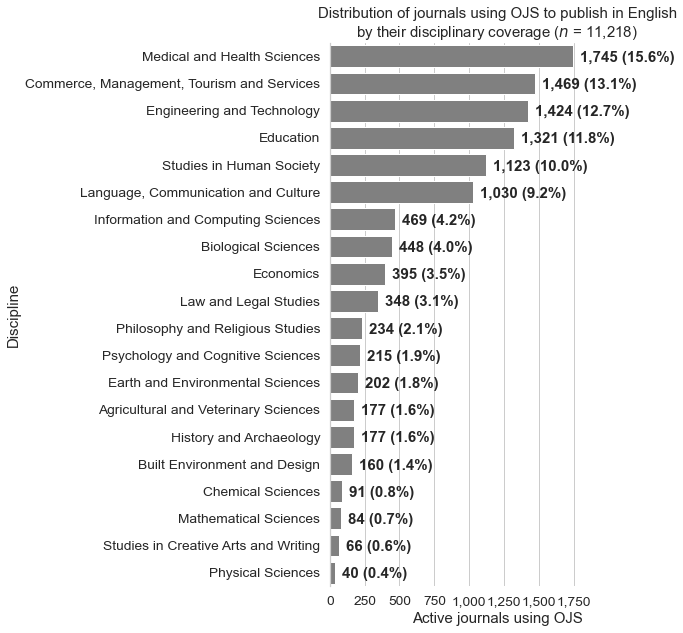

In [35]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=en['discipline'].value_counts().tolist(), y=en['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 2400),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in English\nby their disciplinary coverage ($\it{n}$ = 11,218)')

matplotlib.pyplot.xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750],
                         ['0', '250', '500', '750', '1,000', '1,250', '1,500', '1,750'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.2
    percent = round(((p.get_width() / 11218) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 50, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'ENdisciplines.png'), bbox_inches='tight')

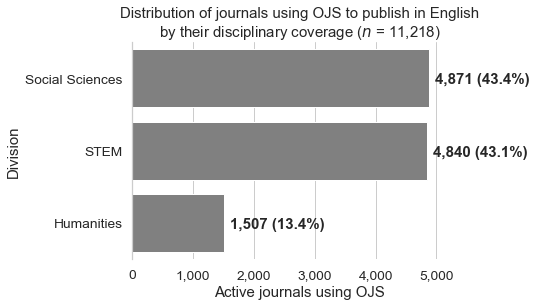

In [36]:
fig, ax = plt.subplots()

sns.barplot(x=en['division'].value_counts().tolist(), y=en['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 5500),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in English\nby their disciplinary coverage ($\it{n}$ = 11,218)')

matplotlib.pyplot.xticks([0, 1000, 2000, 3000, 4000, 5000],
                         ['0', '1,000', '2,000', '3,000', '4,000', '5,000'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 11218) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 100, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'ENdivisions.png'), bbox_inches='tight')

#### Bahasa Indonesia:

In [37]:
bid = ldF[ldF['language'] == 'Indonesian']
print(bid.shape)
bid.head(2)

(5178, 5)


,issn,context_name,discipline,language,division
110,2597-9000,LAGA-LAGA : Jurnal Seni Pertunjukan,"Language, Communication and Culture",Indonesian,Humanities
388,2613-9103,J-ADIMAS (Jurnal Pengabdian Kepada Masyarakat),Education,Indonesian,Social Sciences


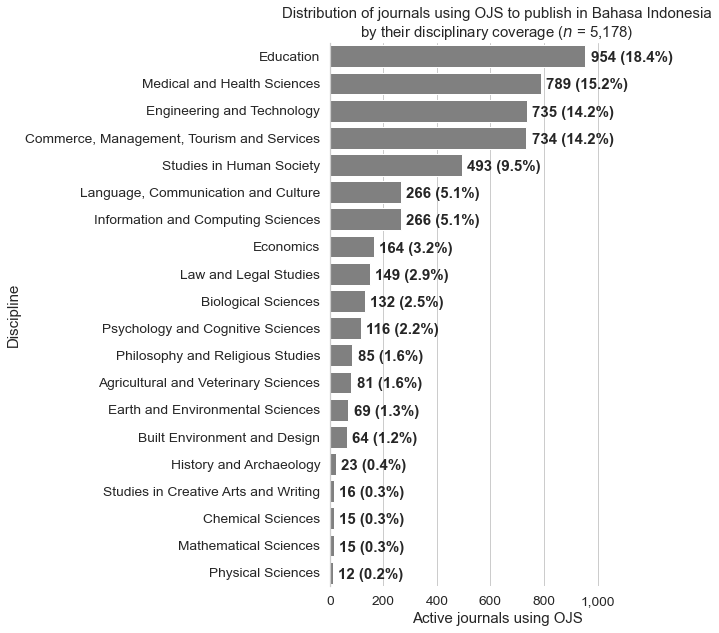

In [38]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=bid['discipline'].value_counts().tolist(), y=bid['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 1250),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in Bahasa Indonesia\nby their disciplinary coverage ($\it{n}$ = 5,178)')

matplotlib.pyplot.xticks([0, 200, 400, 600, 800, 1000],
                         ['0', '200', '400', '600', '800', '1,000'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.1825
    percent = round(((p.get_width() / 5178) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 20, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'IDdisciplines.png'), bbox_inches='tight')

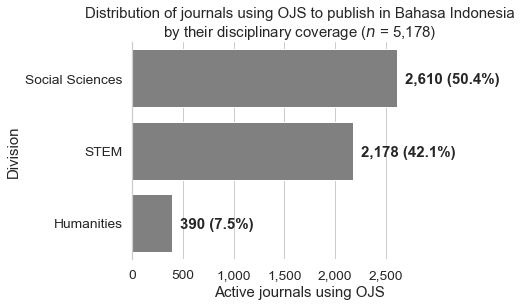

In [39]:
fig, ax = plt.subplots()

sns.barplot(x=bid['division'].value_counts().tolist(), y=bid['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 3300),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in Bahasa Indonesia\nby their disciplinary coverage ($\it{n}$ = 5,178)')

matplotlib.pyplot.xticks([0, 500, 1000, 1500, 2000, 2500],
                         ['0', '500', '1,000', '1,500', '2,000', '2,500'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 5178) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 80, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'IDdivisions.png'), bbox_inches='tight')

#### Spanish:

In [40]:
es = ldF[ldF['language'] == 'Spanish']
print(es.shape)
es.head(2)

(2574, 5)


,issn,context_name,discipline,language,division
1,2444-9431,MULTIárea. Revista de didáctica,Studies in Human Society,Spanish,Social Sciences
2,2478-9127,Neuróptica,"Language, Communication and Culture",Spanish,Humanities


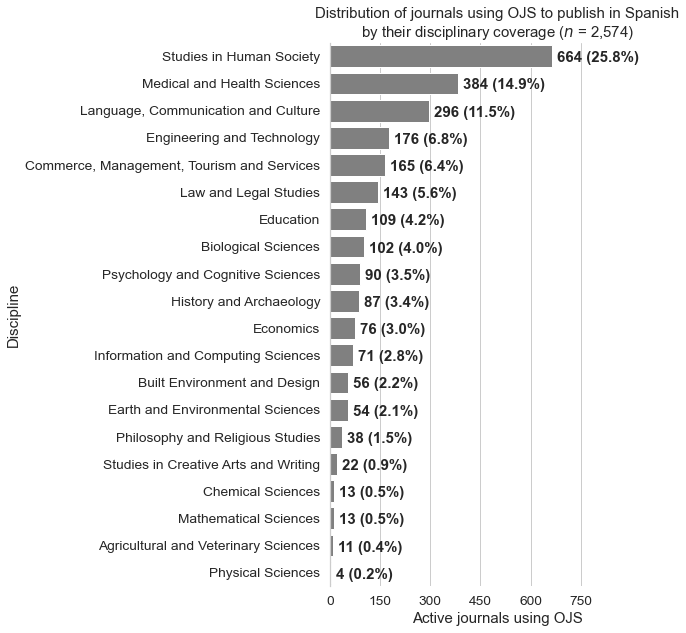

In [41]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=es['discipline'].value_counts().tolist(), y=es['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 1000),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in Spanish\nby their disciplinary coverage ($\it{n}$ = 2,574)')

matplotlib.pyplot.xticks([0, 150, 300, 450, 600, 750],
                         ['0', '150', '300', '450', '600', '750'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.1825
    percent = round(((p.get_width() / 2574) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 15, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'ESdisciplines.png'), bbox_inches='tight')

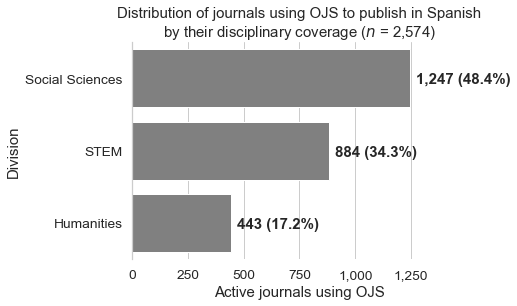

In [42]:
fig, ax = plt.subplots()

sns.barplot(x=es['division'].value_counts().tolist(), y=es['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 1500),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in Spanish\nby their disciplinary coverage ($\it{n}$ = 2,574)')

matplotlib.pyplot.xticks([0, 250, 500, 750, 1000, 1250],
                         ['0', '250', '500', '750', '1,000', '1,250'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 2574) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 25, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'ESdivisions.png'), bbox_inches='tight')

#### Portuguese:

In [43]:
pt = ldF[ldF['language'] == 'Portuguese']
print(pt.shape)
pt.head(2)

(2205, 5)


,issn,context_name,discipline,language,division
0,2175-2516,A MARgem - Revista Eletrônica de Ciências Huma...,"Language, Communication and Culture",Portuguese,Humanities
3,1517-5529,Cadernos PET-Filosofia,Studies in Human Society,Portuguese,Social Sciences


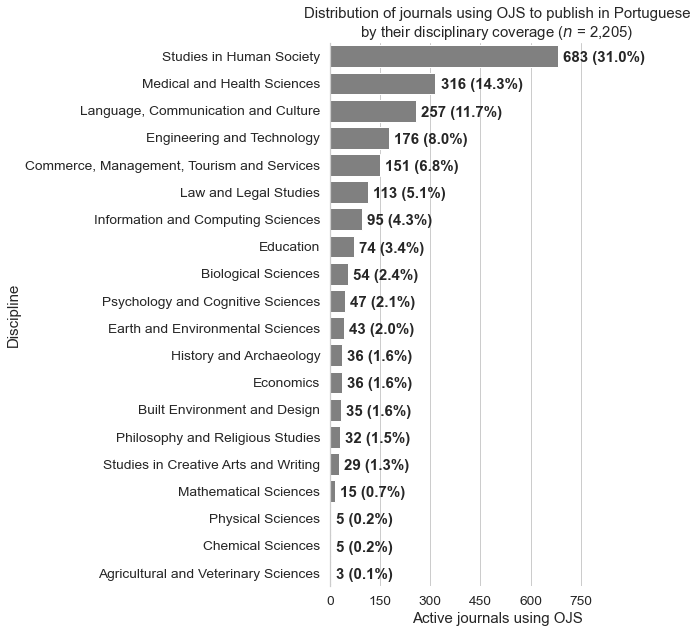

In [44]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=pt['discipline'].value_counts().tolist(), y=pt['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 1000),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in Portuguese\nby their disciplinary coverage ($\it{n}$ = 2,205)')

matplotlib.pyplot.xticks([0, 150, 300, 450, 600, 750],
                         ['0', '150', '300', '450', '600', '750'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.1825
    percent = round(((p.get_width() / 2205) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 15, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'PTdisciplines.png'), bbox_inches='tight')

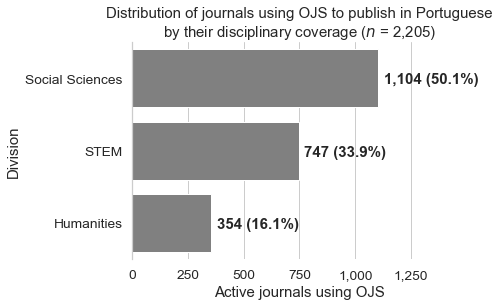

In [45]:
fig, ax = plt.subplots()

sns.barplot(x=pt['division'].value_counts().tolist(), y=pt['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 1500),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in Portuguese\nby their disciplinary coverage ($\it{n}$ = 2,205)')

matplotlib.pyplot.xticks([0, 250, 500, 750, 1000, 1250],
                         ['0', '250', '500', '750', '1,000', '1,250'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 2205) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 25, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'PTdivisions.png'), bbox_inches='tight')

#### Ukrainian:

In [46]:
uk = ldF[ldF['language'] == 'Ukrainian']
print(uk.shape)
uk.head(2)

(141, 5)


,issn,context_name,discipline,language,division
816,2708-9436,Актуальні проблеми освіти і науки: досвід та с...,Education,Ukrainian,Social Sciences
1845,2309-1533,ІННОВАЦІЙНА ЕКОНОМІКА,"Commerce, Management, Tourism and Services",Ukrainian,Social Sciences


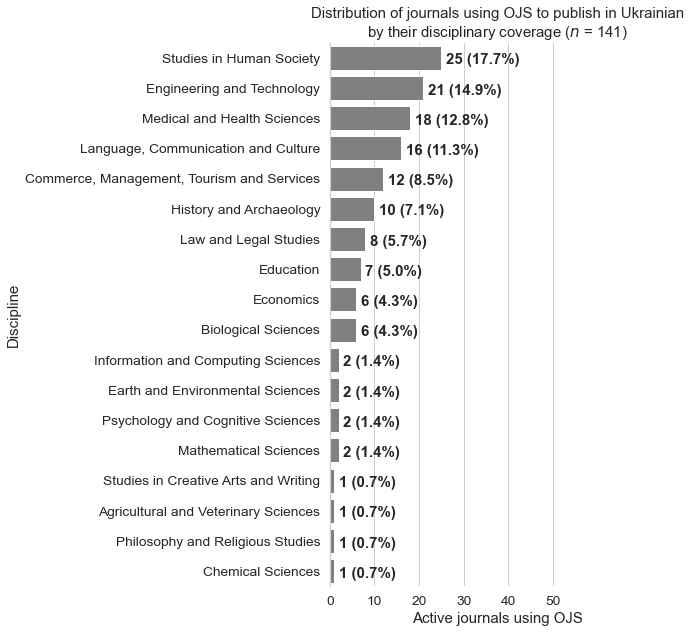

In [47]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=uk['discipline'].value_counts().tolist(), y=uk['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 75),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in Ukrainian\nby their disciplinary coverage ($\it{n}$ = 141)')

matplotlib.pyplot.xticks([0, 10, 20, 30, 40, 50],
                         ['0', '10', '20', '30', '40', '50'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.1825
    percent = round(((p.get_width() / 141) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 1, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'UKdisciplines.png'), bbox_inches='tight')

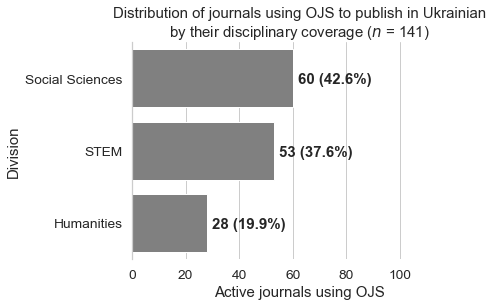

In [48]:
fig, ax = plt.subplots()

sns.barplot(x=uk['division'].value_counts().tolist(), y=uk['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 125),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in Ukrainian\nby their disciplinary coverage ($\it{n}$ = 141)')

matplotlib.pyplot.xticks([0, 20, 40, 60, 80, 100],
                         ['0', '20', '40', '60', '80', '100'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 141) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 2, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'UKdivisions.png'), bbox_inches='tight')

#### Russian:

In [49]:
ru = ldF[ldF['language'] == 'Russian']
print(ru.shape)
ru.head(2)

(138, 5)


,issn,context_name,discipline,language,division
808,2410-2644,"""Ребёнок и общество""",Studies in Human Society,Russian,Social Sciences
809,2686-9497,Сборник трудов Якутской духовной семинарии,Philosophy and Religious Studies,Russian,Humanities


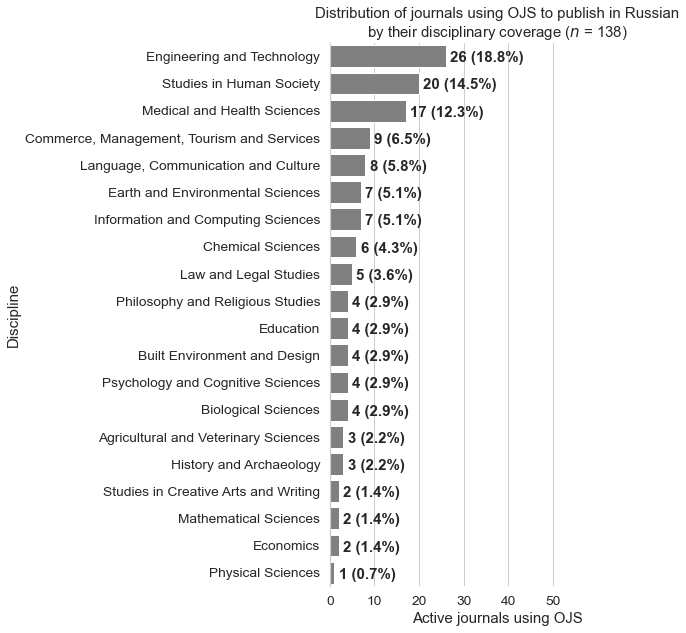

In [50]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=ru['discipline'].value_counts().tolist(), y=ru['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 75),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in Russian\nby their disciplinary coverage ($\it{n}$ = 138)')

matplotlib.pyplot.xticks([0, 10, 20, 30, 40, 50],
                         ['0', '10', '20', '30', '40', '50'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.1825
    percent = round(((p.get_width() / 138) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 1, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'RUdisciplines.png'), bbox_inches='tight')

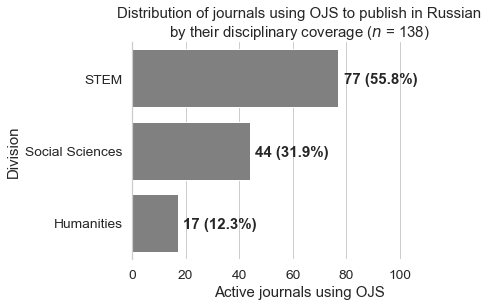

In [51]:
fig, ax = plt.subplots()

sns.barplot(x=ru['division'].value_counts().tolist(), y=ru['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 125),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in Russian\nby their disciplinary coverage ($\it{n}$ = 138)')

matplotlib.pyplot.xticks([0, 20, 40, 60, 80, 100],
                         ['0', '20', '40', '60', '80', '100'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 138) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 2, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'RUdivisions.png'), bbox_inches='tight')

#### German:

In [52]:
de = ldF[ldF['language'] == 'German']
print(de.shape)
de.head(2)

(130, 5)


,issn,context_name,discipline,language,division
2040,2510-3520,Journal für Sportkommunikation und Mediensport,"Language, Communication and Culture",German,Humanities
3104,2673-4664,Society - the Individual - Socialisation: Jour...,Education,German,Social Sciences


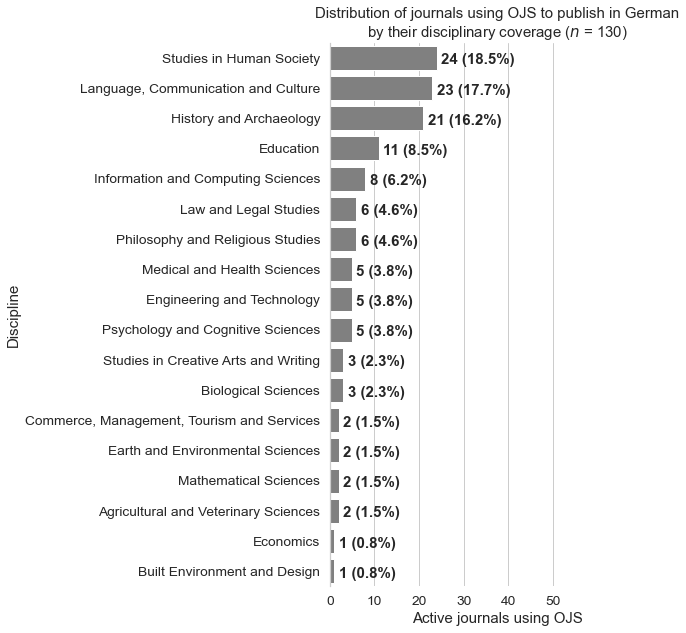

In [53]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=de['discipline'].value_counts().tolist(), y=de['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 75),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in German\nby their disciplinary coverage ($\it{n}$ = 130)')

matplotlib.pyplot.xticks([0, 10, 20, 30, 40, 50],
                         ['0', '10', '20', '30', '40', '50'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.1825
    percent = round(((p.get_width() / 130) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 1, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'DEdisciplines.png'), bbox_inches='tight')

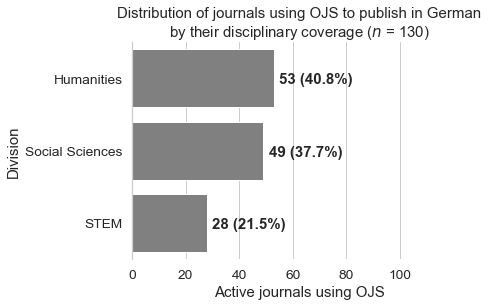

In [54]:
fig, ax = plt.subplots()

sns.barplot(x=de['division'].value_counts().tolist(), y=de['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 125),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in German\nby their disciplinary coverage ($\it{n}$ = 130)')

matplotlib.pyplot.xticks([0, 20, 40, 60, 80, 100],
                         ['0', '20', '40', '60', '80', '100'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 130) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 2, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'DEdivisions.png'), bbox_inches='tight')

#### Polish:

In [55]:
pl = ldF[ldF['language'] == 'Polish']
print(pl.shape)
pl.head(2)

(106, 5)


,issn,context_name,discipline,language,division
3076,2300-2905,Biznesmaniak,"Commerce, Management, Tourism and Services",Polish,Social Sciences
3085,2543-9421,Konwersatorium Wiedzy o Mieście,Studies in Human Society,Polish,Social Sciences


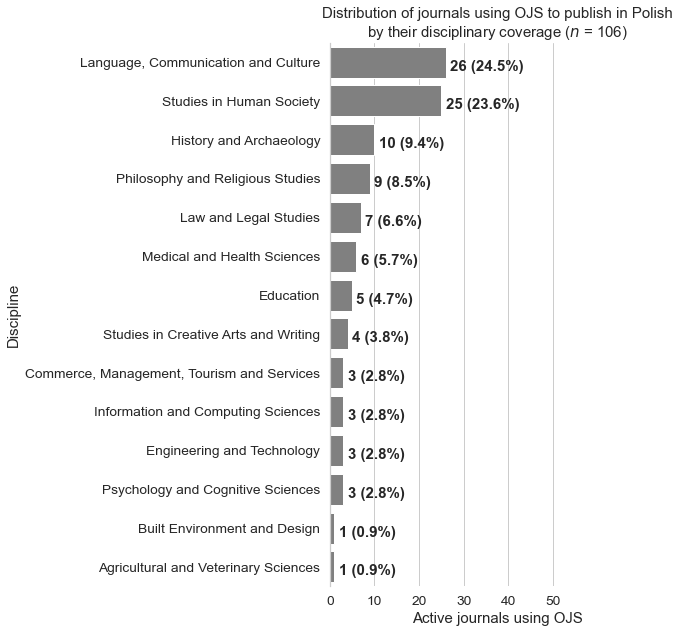

In [56]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=pl['discipline'].value_counts().tolist(), y=pl['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 75),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in Polish\nby their disciplinary coverage ($\it{n}$ = 106)')

matplotlib.pyplot.xticks([0, 10, 20, 30, 40, 50],
                         ['0', '10', '20', '30', '40', '50'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.1825
    percent = round(((p.get_width() / 106) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 1, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'PLdisciplines.png'), bbox_inches='tight')

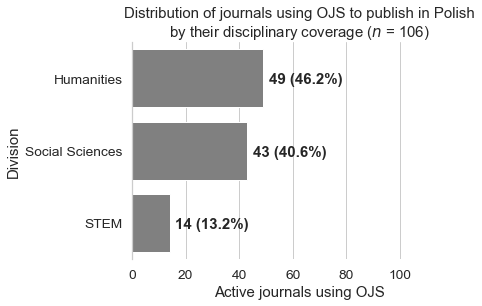

In [57]:
fig, ax = plt.subplots()

sns.barplot(x=pl['division'].value_counts().tolist(), y=pl['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 125),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in Polish\nby their disciplinary coverage ($\it{n}$ = 106)')

matplotlib.pyplot.xticks([0, 20, 40, 60, 80, 100],
                         ['0', '20', '40', '60', '80', '100'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 106) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 2, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'PLdivisions.png'), bbox_inches='tight')

#### French:

In [58]:
fr = ldF[ldF['language'] == 'French']
print(fr.shape)
fr.head(2)

(96, 5)


,issn,context_name,discipline,language,division
215,2033-3013,Regards économiques,Studies in Human Society,French,Social Sciences
670,2550-6498,Langues et Langage,"Language, Communication and Culture",French,Humanities


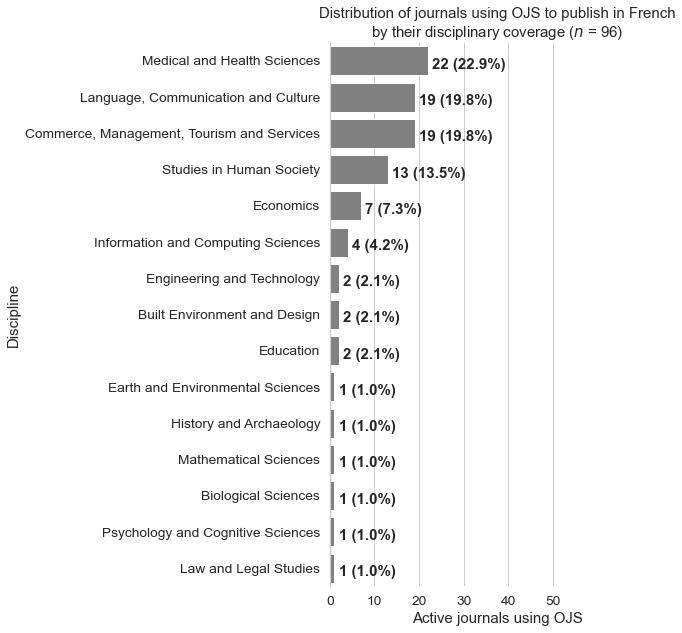

In [59]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=fr['discipline'].value_counts().tolist(), y=fr['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 75),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in French\nby their disciplinary coverage ($\it{n}$ = 96)')

matplotlib.pyplot.xticks([0, 10, 20, 30, 40, 50],
                         ['0', '10', '20', '30', '40', '50'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.1825
    percent = round(((p.get_width() / 96) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 1, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'FRdisciplines.png'), bbox_inches='tight')

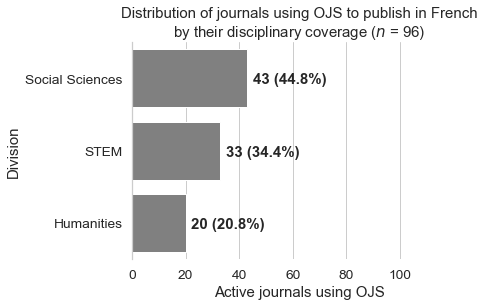

In [60]:
fig, ax = plt.subplots()

sns.barplot(x=fr['division'].value_counts().tolist(), y=fr['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 125),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in French\nby their disciplinary coverage ($\it{n}$ = 96)')

matplotlib.pyplot.xticks([0, 20, 40, 60, 80, 100],
                         ['0', '20', '40', '60', '80', '100'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 96) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 2, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'FRdivisions.png'), bbox_inches='tight')

#### Arabic:

In [61]:
ar = ldF[ldF['language'] == 'Arabic']
print(ar.shape)
ar.head(2)

(88, 5)


,issn,context_name,discipline,language,division
802,2655-3325,AL-AF'IDAH: Jurnal Pendidikan Bahasa Arab dan ...,"Language, Communication and Culture",Arabic,Humanities
826,2706-5820,الجامعي,Biological Sciences,Arabic,STEM


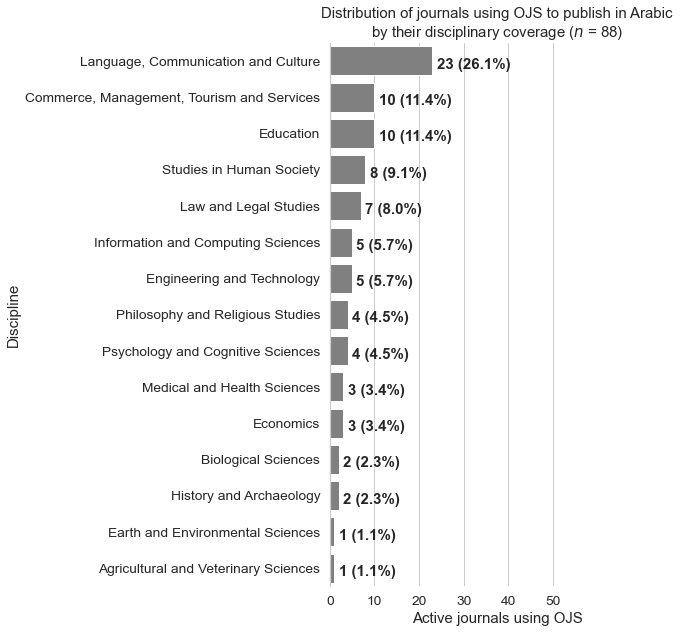

In [62]:
fig, ax = plt.subplots(figsize=(6,10))

sns.barplot(x=ar['discipline'].value_counts().tolist(), y=ar['discipline'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 75),
       xlabel = 'Active journals using OJS',
       ylabel = 'Discipline',
       title = 'Distribution of journals using OJS to publish in Arabic\nby their disciplinary coverage ($\it{n}$ = 88)')

matplotlib.pyplot.xticks([0, 10, 20, 30, 40, 50],
                         ['0', '10', '20', '30', '40', '50'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.1825
    percent = round(((p.get_width() / 88) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 1, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'ARdisciplines.png'), bbox_inches='tight')

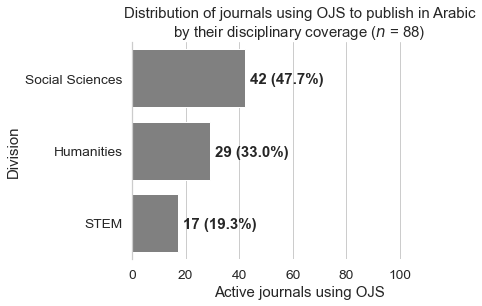

In [63]:
fig, ax = plt.subplots()

sns.barplot(x=ar['division'].value_counts().tolist(), y=ar['division'].value_counts().index,
            label="Total", color="grey")

sns.despine(bottom=True)

ax.set(xlim=(0, 125),
       xlabel = 'Active journals using OJS',
       ylabel = 'Division',
       title = 'Distribution of journals using OJS to publish in Arabic\nby their disciplinary coverage ($\it{n}$ = 88)')

matplotlib.pyplot.xticks([0, 20, 40, 60, 80, 100],
                         ['0', '20', '40', '60', '80', '100'])

for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.33
    percent = round(((p.get_width() / 88) * 100), 1)
    if len(str(int(p.get_width()))) == 4:
        value = str(int(p.get_width()))[0] + ',' + str(int(p.get_width()))[1:] + ' ({})'.format(str(percent)+'%')
    else:
        value = str(int(p.get_width())) + ' ({})'.format(str(percent)+'%')
    ax.text(_x + 2, _y, value, ha='left', weight='bold')

plt.savefig(os.path.join('vis', 'ARdivisions.png'), bbox_inches='tight')